### Imports

In [1]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
from biotuner.dictionaries import *
import matplotlib.pyplot as plt
import pytuning.visualizations.scales
from pytuning.visualizations.scales import consonance_matrix
import csv
import os
import time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

pygame 2.1.2 (SDL 2.0.18, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Constructing musical tunings with biosignals

This notebook is intended to demonstrate the use of the biotuner for tuning construction. To do so, we will explore how different tuning construction methods developed in the field of music theory can be integrated with electrophysiological signal processing techniques. 

The terms ''*tuning*'' and ''*scale*'' will be used interchangeably, referring to a series of ratios that subdivides an octave.

### Table of content

1. [Spectral peaks extraction](#1-spectral-peaks-extraction)
2. [Deriving tuning from peaks ratios](#2-deriving-tuning-from-peaks-ratios)
3. [Dissonance curve](#3-dissonance-curve)
4. [Harmonic entropy](#4-harmonic-entropy)
5. [Classical tuning creation](#5-classical-tuning-creation)

    5.1. [Euler-Fokker Genera](#51-euler-fokker-genera)
    
    5.2. [Harmonic scale](#52-harmonic-scale)
        
        5.2.1. Using harmonic recurrence
        5.2.2. Using inter-harmonic concordance

6. [Scale reduction](#6-scale-reduction)
7. [Exporting scale in scala format](#7-exporting-scale-in-scala-format)
8. [Plotting consonance matrix for a specific scale](#8-plotting-consonance-matrix-for-a-specific-scale)
9. [Computing scale metrics](#9-computing-scale-metrics)
10. [Visualizing ratios with Lissajous curves](#10-visualizing-ratios-with-lissajous-curves)
11. [Listening to scales](#11-listening-to-scales-and-chords)

## 1. Spectral peaks extraction

### Load dataset

In [2]:
data = np.load('data_examples/EEG_pareidolia/parei_data_1000ts.npy')

### Extract spectral peaks

The first step is to initialize the biotuner object by calling *compute_biotuner* and then applying the method *peaks_extraction*. 

The *peaks_function* argument determines how spectral peaks are extracted. Here the 'fixed' method is used, where predetermined frequency bands are used to find one spectral peak associated with each band.

There is no minimum size for time series. However, keep in mind that the minimum frequency that can be observed using spectral decomposition is dependant on the length of your time series. For example, if the sampling frequency equals 1000Hz, time series shorter than 1 second will not allow for peak extraction below 2Hz. Also, note that the *precision* argument influences the size of the fft and higher precision requires longer time series (e.g. 0.1Hz of precision at 1000Hz of sampling frequency requires 10 seconds of signal).

In [3]:
# Define frequency bands for peaks_function = 'fixed'
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 18], [18, 30], [30, 45]] 

# Select a single time series
data_ = data[28]
start = time.time()

# Initialize biotuner object
biotuning = compute_biotuner(sf = 1000, peaks_function = 'fixed', precision = 0.5, n_harm = 10)

# Extract spectral peaks
biotuning.peaks_extraction(data_, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 30, n_peaks=5,
                          graph=False, min_harms=2)

stop = time.time()
print(stop-start)

Index_max: all zeros indicate 1/f trend [0, 7, 2, 11, 1, 17]
Number of peaks : 6
0.007032632827758789


In [4]:
# Print the extracted peaks
biotuning.peaks

array([ 1. ,  6.5,  8. , 17.5, 18.5, 38.5])

Now that we have shown how spectral peaks can be extracted, we will use these peaks as the basis for the organisation of musical structures. We will show how to derive tunings based on the harmonicity of spectral peaks, expressed as the simplicity of their frequency ratios.

## 2. Deriving tuning from peaks ratios

The simpliest way to derive a tuning from spectral peaks is to use their ratios as steps for dividing the octave. An attribute of the biotuner object provides this information.

In [5]:
biotuning.peaks_ratios 

[1.0405405405405406,
 1.0571428571428572,
 1.09375,
 1.1,
 1.15625,
 1.203125,
 1.2307692307692308,
 1.3461538461538463,
 1.4230769230769231,
 1.4807692307692308,
 1.625,
 2.0]

You can also derive a tuning from extended peaks ratios as well as from extended peaks ratios with higher consonance levels. Extended peaks correspond to a set of frequencies based on the harmonic congruence of spectral peaks.

In [6]:
biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult',  n_harm = 20, 
                          cons_limit = 0.129, ratios_extension = True, scale_cons_limit = 0.129) 
print(np.sort(biotuning.extended_peaks_ratios))

Number of extended peaks :  11
[1.04 1.06 1.09 1.1  1.16 1.2  1.23 1.25 1.3  1.35 1.38 1.41 1.42 1.48
 1.49 1.5  1.62 1.85 2.  ]


Since the tuning from extended peaks might have a large number of steps, we could keep only the most consonant ratios. To do so, we adjust the 'scale_cons_limit' value:

Comparisons with familiar ratios:
        
        #Unison-frequency ratio 1:1 yields a value of 2
        Octave-frequency ratio 2:1 yields a value of 1.5
        Perfect 5th-frequency ratio 3:2 yields a value of 0.833
        Perfect 4th-frequency ratio 4:3 yields a value of 0.583
        Major 6th-frequency ratio 5:3 yields a value of 0.533
        Major 3rd-frequency ratio 5:4 yields a value of 0.45
        Minor 3rd-frequency ratio 5:6 yields a value of 0.366
        Minor 6th-frequency ratio 5:8 yields a value of 0.325
        Major 2nd-frequency ratio 8:9 yields a value of 0.236
        Major 7th-frequency ratio 8:15 yields a value of 0.192
        Minor 7th-frequency ratio 9:16 yields a value of 0.174
        Minor 2nd-frequency ratio 15:16 yields a value of 0.129

In [7]:
biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult',  n_harm = 30, 
                          cons_limit = 0.1, ratios_extension = True, scale_cons_limit = 0.129) 
print(biotuning.extended_peaks_ratios_cons)

biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult',  n_harm = 30, 
                          cons_limit = 0.1, ratios_extension = True, scale_cons_limit = 0.236) 
print(biotuning.extended_peaks_ratios_cons)

Number of extended peaks :  14
[1.083 1.1   1.231 1.25  1.375 1.5   1.625 2.   ]
Number of extended peaks :  14
[1.25 1.5  2.  ]


## 3. Dissonance curve

The dissonance curve has been introduced by William Sethares showing how the harmonic structure that constitutes a timbre can be reflected in scale construction, allowing to find tunings that will match the timbral structure. I strongly recommend reading his book [Tuning, Timbre, Spectrum and Scale](https://sethares.engr.wisc.edu/ttss.html).

The dissonance curve takess as input list of peaks and their associated amplitudes. Since providing less than 6 spectral peaks would lead to less interesting dissonance curve, the method ''peaks_extension'' provides a way to extend the number of peaks based on the harmonic_fit function (see biotuner.py)

peaks_extension methods: 
['harmonic_fit', 'consonant', 'multi_consonant', 'consonant_harmonic_fit', 'multi_consonant_harmonic_fit']

Number of extended peaks :  11


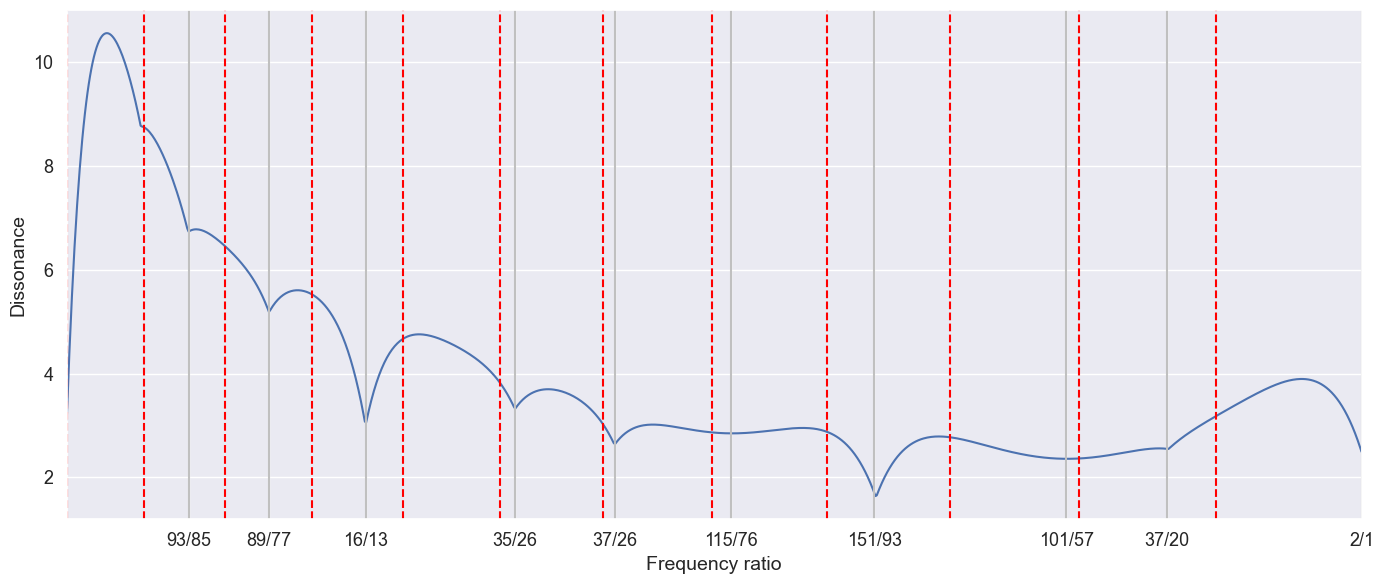

In [8]:
# Extend spectral peaks based on their inter-harmonic concordance
biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult',  n_harm = 20, cons_limit = 0.05, 
                          ratios_extension = True, scale_cons_limit = 0.1)
# Compute the dissonance curve
biotuning.compute_diss_curve(plot = True, input_type = 'extended_peaks', euler_comp = False, denom = 100, max_ratio = 2, n_tet_grid = 12)


In [9]:
print('Dissonance curve metrics:', biotuning.scale_metrics)
print('Dissonance curve tuning:', biotuning.diss_scale)
print('Dissonance curve consonant tuning:', biotuning.diss_scale_cons)

Dissonance curve metrics: {'diss_euler': 'NaN', 'dissonance': 3.9844954535203048, 'diss_harm_sim': 5.038404472654177, 'diss_n_steps': 10}
Dissonance curve tuning: [1.0941176470588236, 1.155844155844156, 1.2307692307692308, 1.3461538461538463, 1.4230769230769231, 1.513157894736842, 1.6236559139784945, 1.7719298245614035, 1.85, 2.0]
Dissonance curve consonant tuning: [1.231 2.   ]


In [10]:
### If you want the tuning in fraction
scale_frac, num, denom = scale2frac(biotuning.diss_scale, maxdenom = 1000)
scale_frac

[93/85, 89/77, 16/13, 35/26, 37/26, 115/76, 151/93, 101/57, 37/20, 2]

## 4. Harmonic entropy

[Harmonic entropy]('https://en.xen.wiki/w/Harmonic_entropy') is a simple model to quantify the extent to which musical chords exhibit various psychoacoustic effects, lumped together in a single construct called psychoacoustic concordance.

The *compute_harmonic_entropy* method takes as input a list of ratios.

If *input_type* is set to '*peaks*' or *'extended_peaks'*, their ratios will be used.
Other input types use extended ratios : see biotuner ref.

'extended_ratios_inc'  (increments of the ratios in the form of *r^1, r^2, r^3, ... r^n*)

'extended_ratios_inc_fit' (harmonic fit between the ratios increments)

'extended_ratios_harm' (harmonics of the ratios in the form *rx1, rx2, rx3, ... rxn*)


Number of peaks : 5
Number of extended peaks :  24


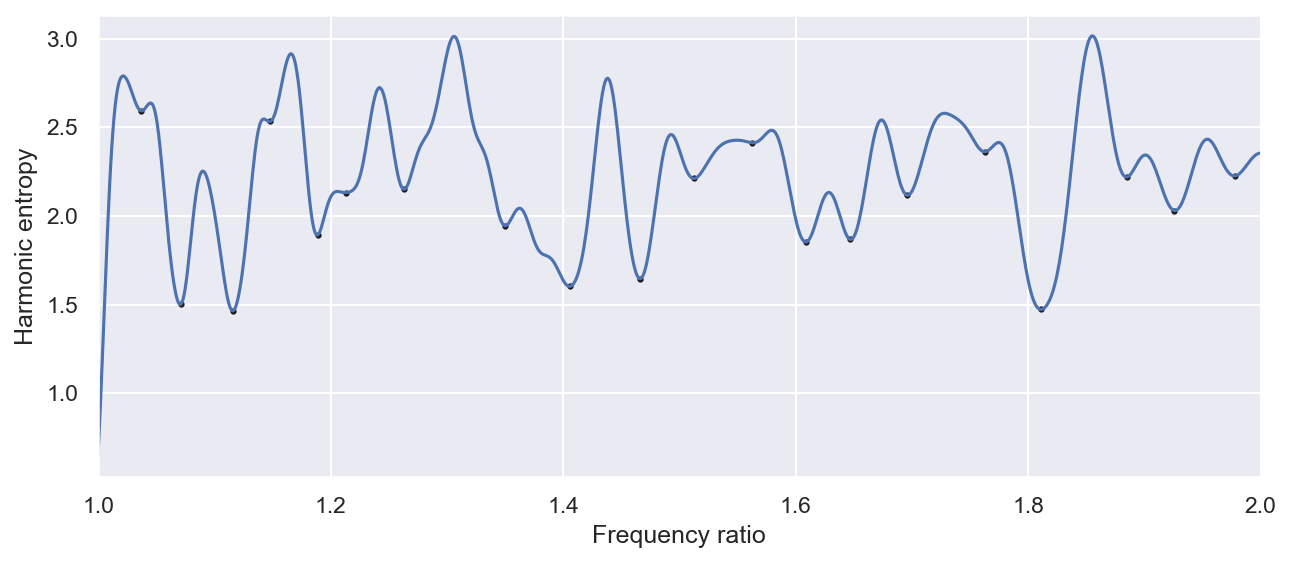

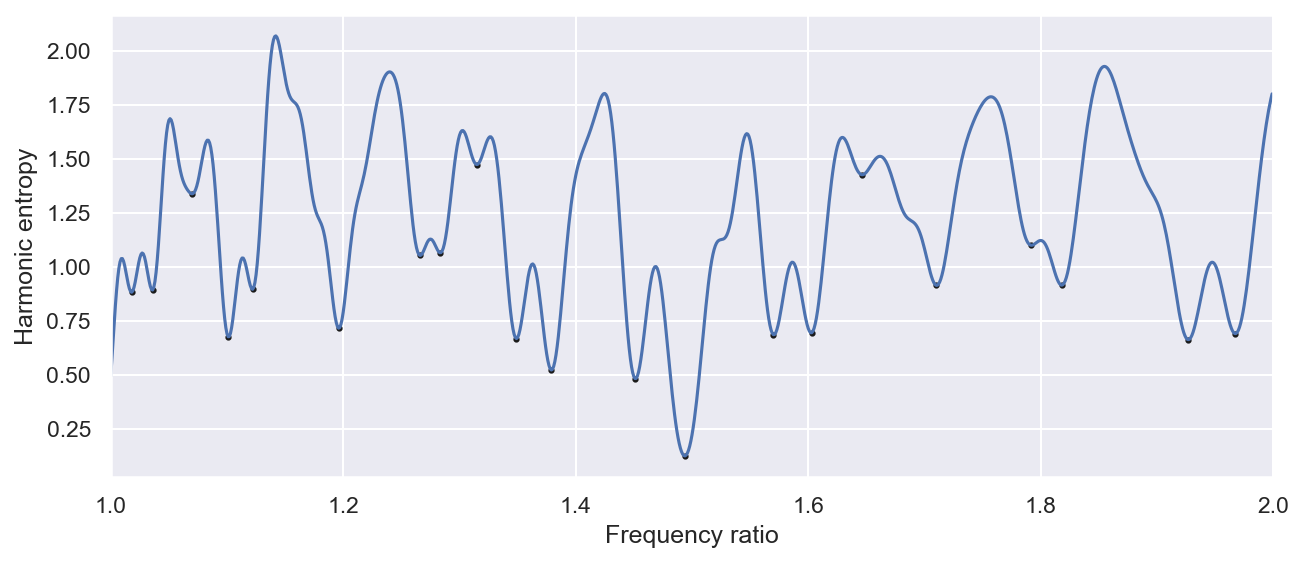

In [11]:
# Initialize biotuner object, specifying that you want ratios increments and harmonics to be computed
biotuning = compute_biotuner(sf = 1000, peaks_function = 'harmonic_recurrence', precision = 0.5, n_harm = 30,
                             ratios_inc=True, ratios_harms=True, ratios_inc_fit=True)
# Extract spectral peaks
biotuning.peaks_extraction(data_, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 30, n_peaks=5,
                          graph=False, min_harms=2)
# compute the extended peaks by finding inter-harmonic concordance.
biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult',  n_harm = 30, 
                          cons_limit = 0.1, ratios_extension = True)
# compute the harmonic entropy curve as a function of extended ratios increments.
biotuning.compute_harmonic_entropy(input_type = 'extended_ratios_inc', plot_entropy = True, octave = 2, rebound = False, 
                                   scale_cons_limit = 0.01, sub=False)

# compute the harmonic entropy curve as a function of extended ratios harmonics.
biotuning.compute_harmonic_entropy(input_type = 'extended_ratios_harms', plot_entropy = True, octave = 2, rebound = False, 
                                   scale_cons_limit = 0.01, sub=False)

In [12]:
print('Harmonic entropy metrics:', biotuning.scale_metrics)
print('Harmonic entropy tuning:', biotuning.HE_scale)
print('Harmonic entropy consonant tuning:', biotuning.HE_scale_cons)

Harmonic entropy metrics: {'HE': 1.2165484571397156, 'HE_n_steps': 21, 'HE_harm_sim': 0.5818470682340359}
Harmonic entropy tuning: [1.018 1.036 1.07  1.101 1.122 1.196 1.266 1.283 1.315 1.349 1.379 1.451
 1.494 1.57  1.603 1.646 1.71  1.792 1.818 1.927 1.967]
Harmonic entropy consonant tuning: [1.07  1.57  1.71  1.792]


In [13]:
# If you want the tuning in fraction
scale_frac, num, denom = scale2frac (biotuning.HE_scale, maxdenom = 100)
print(scale_frac)

[57/56, 86/83, 107/100, 109/99, 46/41, 61/51, 119/94, 68/53, 96/73, 58/43, 131/95, 74/51, 124/83, 157/100, 109/68, 107/65, 171/100, 138/77, 20/11, 185/96, 179/91]


## 5. Classical tuning creation

We will see in this section how to use spectral peaks and their ratios to derive tunings based on Euler-Fokker Genera, Harmonic positions and Generator Intervals

### 5.1. Euler-Fokker Genera

[Euler-Fokker genera](https://en.wikipedia.org/wiki/Euler%E2%80%93Fokker_genus) are musical scale in just intonation whose pitches can be expressed as products of some of the members of some multiset of generating prime factors. 

In [14]:
# Initialize biotuner object
BT_EFG = compute_biotuner(sf = 1000, peaks_function = 'harmonic_recurrence', precision = 0.5,
                                          n_harm = 15, ratios_n_harms = 5, ratios_inc_fit = True,
                                          ratios_inc = True)

# Extract spectral peaks
BT_EFG.peaks_extraction(data_, ratios_extension = True, max_freq = 50)

# Use peaks as generators (using method)
print('Generators :', BT_EFG.peaks)
BT_EFG.euler_fokker_scale()

Number of peaks : 5
Generators : [ 2.   6.5  8.   3.5 11.5]


[1, 33/32, 11/8, 3/2, 2]

In [15]:
from biotuner.scale_construction import euler_fokker_scale

# compute extended peaks
BT_EFG.peaks_extension(method = 'harmonic_fit', harm_function = 'mult', 
                                       n_harm = 10, cons_limit = 0.1, ratios_extension = True)

# Use extended peaks as generators (using function)
EFG_scale = euler_fokker_scale(BT_EFG.extended_peaks)

# print the scale steps with associated names
scale_interval_names(EFG_scale, reduce = False)

Number of extended peaks :  8


[[1, 'Unison'],
 [33/32, 'Thrty-third Harmonic'],
 [9/8, 'Pythagorean Major Second'],
 [77/64, 'Seventy-seventh Harmonic'],
 [21/16, '21st Harmonic'],
 [693/512, None],
 [11/8, 'Eleventh Harmonic'],
 [3/2, 'Perfect Fifth'],
 [99/64, 'Ninety-ninth Harmonic'],
 [7/4, 'Septimal Minor Seventh'],
 [231/128, None],
 [63/32, 'Sixty-third Harmonic'],
 [2, 'Octave']]

### 5.2. Harmonic scale

Harmonic scales are constructed by transforming a set of harmonic positions into ratios falling between the unison (1) and the octave (2). For example, using the harmonics 3, 5 and 7 would yields a scale of 1, 1.5, 1.25 and 1.75, since 3/2=1.5, 5/2^2 = 1.25 and 7/2^2 = 1.75



##### 5.2.1. Using harmonic recurrence

The harmonic recurrence method computes all peaks of the spectrum, and keeps peaks for which a maximum of other peaks are harmonics. This method gives as an ouput the peaks and the positions of congruent harmonics. The *max_freq* argument determines the maximum frequency that can be choose as a peak. The *min_harms* argument indicates the minimum number of congruent harmonics to keep the peak. 

In [16]:
# Initialize biotuner object
biotuning_harm_peaks = compute_biotuner(sf = 1000, peaks_function = 'harmonic_recurrence', precision = 0.5) 

# Extract spectral peaks with minimum of 2 recurrent harmonics
biotuning_harm_peaks.peaks_extraction(data_, min_freq = 5, max_freq = 20, min_harms = 2, harm_limit = 128)
print(biotuning_harm_peaks.all_harmonics)

# Extract spectral peaks with minimum of 4 recurrent harmonics
biotuning_harm_peaks.peaks_extraction(data_, min_freq = 5, max_freq = 20, min_harms = 4, harm_limit = 128)
print(biotuning_harm_peaks.all_harmonics)

Number of peaks : 5
[ 2.  3.  5.  6.  7.  8.  9. 10. 12. 14. 18. 19. 20. 21. 23. 30. 31. 37.
 41. 42. 45. 52. 60. 62. 66. 67. 71. 73.]
Number of peaks : 3
[ 2.  5.  6.  7.  8.  9. 10. 12. 18. 19. 20. 21. 30. 31. 42. 45. 52. 60.
 62. 66. 67. 71. 73.]


In [17]:
# deriving harmonic tuning from recurrent harmonics
harm_tuning = harmonic_tuning(biotuning_harm_peaks.all_harmonics)
print(harm_tuning)

[1.03125, 1.046875, 1.109375, 1.125, 1.140625, 1.1875, 1.25, 1.3125, 1.40625, 1.5, 1.625, 1.75, 1.875, 1.9375, 2.0]


Instead of using all the harmonics, we can use the harmonic positions of a single peak to generate a tuning

In [18]:
# find harmonic positions of first peak
harmonics = biotuning_harm_peaks.harm_peaks_fit[0][1]

# compute harmonic tuning
harm_peak_tuning = harmonic_tuning(harmonics)

# print results
print('Harmonics', [int(x) for x in harmonics])
print('Tuning', harm_peak_tuning)

Harmonics [5, 7, 8, 19, 42, 45, 52, 62, 66, 67, 71, 73]
Tuning [1.03125, 1.046875, 1.109375, 1.140625, 1.1875, 1.25, 1.3125, 1.40625, 1.625, 1.75, 1.9375, 2.0]


We will now compute the harmonicity metrics associated with the tuning

In [19]:
from biotuner.metrics import tuning_to_metrics
metrics = tuning_to_metrics(harm_peak_tuning)
metrics

c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'sum_p_q': 708,
 'sum_distinct_intervals': 132,
 'metric_3': 89.5821733821734,
 'sum_p_q_for_all_intervals': 12718,
 'sum_q_for_all_intervals': 5238,
 'harm_sim': 20.53,
 'matrix_harm_sim': 7.408307919171108,
 'matrix_cons': 0.07770664568642607,
 'matrix_denom': 44.07575757575758}

##### 5.2.2. Using inter-harmonic concordance

This method constructs the harmonic tuning based on the positions of common harmonics of spectral peaks.

In [20]:
# Initialize biotuner object
bt_harm_fit_peaks = compute_biotuner(sf = 1000, peaks_function = 'harmonic_recurrence', precision = 0.5) 

# Extract spectral peaks with minimum of 2 recurrent harmonics
bt_harm_fit_peaks.peaks_extraction(data_, min_freq = 5, max_freq = 20, min_harms = 2, harm_limit = 128)
print(biotuning_harm_peaks.all_harmonics)

# Compute the harmonic tuning
harm_tuning2 = bt_harm_fit_peaks.harmonic_fit_tuning(n_harm =128, bounds = 0.1, n_common_harms = 50)
print(harm_tuning2)


Number of peaks : 5
[ 2.  5.  6.  7.  8.  9. 10. 12. 18. 19. 20. 21. 30. 31. 42. 45. 52. 60.
 62. 66. 67. 71. 73.]
[1.015625, 1.078125, 1.15625, 1.21875, 1.25, 1.4375, 1.5, 1.625, 1.734375, 1.75, 1.796875, 2.0]


In [21]:
# Compute harmonicity metrics associated with the tuning
metrics = tuning_to_metrics(harm_tuning2)
metrics

{'sum_p_q': 844,
 'sum_distinct_intervals': 100,
 'metric_3': 102.607080278920,
 'sum_p_q_for_all_intervals': 11938,
 'sum_q_for_all_intervals': 4922,
 'harm_sim': 24.52,
 'matrix_harm_sim': 12.174391250478207,
 'matrix_cons': 0.13362222995375167,
 'matrix_denom': 42.43939393939394}

### 5.3. Scale from generator interval

To derive a scale from a generator interval, the first step is to find which interval will be used based on the harmonic structure of the time series. In this example, we will find the most consonant peaks ratio and use it as a generator interval for tuning construction.

In [22]:
# Define data (single time series)
data_gen = data[40] 

# Initialize biotuner object
bt_gen_int = compute_biotuner(sf = 1000, peaks_function = 'EMD', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

# Extract spectral peaks
bt_gen_int.peaks_extraction(data_gen, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 50)

# Find most consonant peaks ratio
ratios, cons = consonant_ratios(bt_gen_int.peaks, limit = 0.01, input_type = 'peaks', metric = 'harmsim') #finding the intervals
ratio_arg = np.argmax(cons)
cons_ratio = ratios[ratio_arg]

Index_max: all zeros indicate 1/f trend [0, 33, 46, 20, 93, 20]
Number of peaks : 5


c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 10000 is greater than input length  = 9501, using nperseg = 9501
  warnings.warn('nperseg = {0:d} is greater than input length '


The most simple way to derive a scale from a generator interval is to generate an equal temperament tuning, meaning that each step equally spaced on a logarithmic scale. To do so, we take our consonant ratio, and find in how many steps we need to divide the octave to retrieve this ratio within the steps. Then, we generate the NTET with this number of steps. 

In [23]:
from biotuner.biotuner_utils import NTET_ratios
from biotuner.scale_construction import oct_subdiv

# Find potential number of steps to divide the octave
octdiv, _ = oct_subdiv(cons_ratio)
print('Consonant ratio :', ratio2frac(cons_ratio, maxdenom=100), '\nPossible octave subdivisions :', octdiv)

# Construct the NTET
NTET = NTET_ratios(octdiv[0], max_ratio=2)

Consonant ratio : [102, 83] 
Possible octave subdivisions : [37, 74, 121, 158, 195]


The biotuner also provides a function that looks at multiple consonant peaks ratios and find the number of subdivisions that optimize having multiple consonant ratios within the same NTET scale. 

In [24]:
from biotuner.scale_construction import multi_oct_subdiv

# Find optimal NTET from a series of spectral peaks
oct_divs, x = multi_oct_subdiv(
                bt_gen_int.peaks, max_sub=100,
                octave_limit=0.01365,
                octave=2,
                n_scales=10,
                cons_limit=0.01
            )
print('Optimal NTET divides the octave in {} steps'.format(oct_divs[0]))

Optimal NTET divides the octave in 55 steps


Another way to create a tuning from a generator interval is by using the "create_equal_interval_scale" from PyTuning toolbox. In the creation of such scale, the generator interval can either be used directly (making each successive tone a generator interval above the previous tone), or in an inverted sense (making each interval a generator down from the previous). This function starts from the unison and walks down the number specified, walking up for the rest of the intervals.

In [25]:
# Generate the tuning
gen_interval_tuning = pytuning.scales.create_equal_interval_scale(ratios[0], scale_size = 11, number_down_intervals = 6, octave = 2)
gen_interval_tuning = [float(x) for x in gen_interval_tuning]

# Transform the ratios into fractions with controlled maximum denominator.
frac, _, _ = scale2frac(gen_interval_tuning, 64)
# Using smaller denominator limit will maximize the chance to find intervalic names in the dictionary
frac2, _, _ = scale2frac(gen_interval_tuning, 16)

print(scale_interval_names(frac, reduce = False),'\n\n', scale_interval_names(frac2, reduce = False))

[[1, 'Unison'], [61/58, None], [69/62, None], [48/41, None], [57/46, None], [73/56, None], [51/37, None], [74/51, None], [89/58, None], [92/57, None], [115/64, 'Hundred-fifteenth Harmonic'], [2, 'Octave']] 

 [[1, 'Unison'], [17/16, 'Minor Diatonic Semitone'], [10/9, 'Small Just Whole Tone'], [7/6, 'Septimal Minor Third'], [16/13, 'Tridecimal Neutral Third'], [13/10, 'Tridecimal Major Third '], [11/8, 'Eleventh Harmonic'], [16/11, 'Undecimal Semi-diminished Fifth'], [23/15, None], [21/13, None], [9/5, 'Greater Just Minor Seventh'], [2, 'Octave']]


## 6. Scale reduction

When a scale has high number of steps, it might be useful to reduce it to a specific number of steps.

In [27]:
from biotuner.scale_construction import tuning_reduction

# scale reduction based on harmonicity between ratios
tuning_metric, reducted_tuning, mode_metric = tuning_reduction(biotuning.peaks_ratios, mode_n_steps = 4, 
                                                            function = dyad_similarity, ratio_type='pos_harm')
print('Tuning :', np.sort(np.round(biotuning.peaks_ratios, 2)),
      '\nTuning harmonicity :', np.round(tuning_metric, 2),
      '\nMode :', np.sort(reducted_tuning),
      '\nMode harmonicity :', np.round(mode_metric))

Tuning : [1.14 1.23 1.44 1.62 1.64 1.75 1.77 1.86 2.  ] 
Tuning harmonicity : 9.29 
Mode : [1.1429 1.75   1.8571 2.    ] 
Mode harmonicity : 13.0


## 7. Exporting scale in scala format

In [28]:
create_SCL(biotuning.HE_scale, 'Harmonic_entropy_scale')
create_SCL(biotuning.peaks_ratios, 'Peaks_ratios_scale')
create_SCL(biotuning.extended_peaks_ratios_cons, 'consonant_extended_peaks_ratios_scale')


## 8. Plotting consonance matrix for a specific scale

The metric_function can be set to:
- None : the denominator of the normalized ratio
- dyad_similarity : similarity with the harmonic series
- consonance : (a+b)/(a*b)

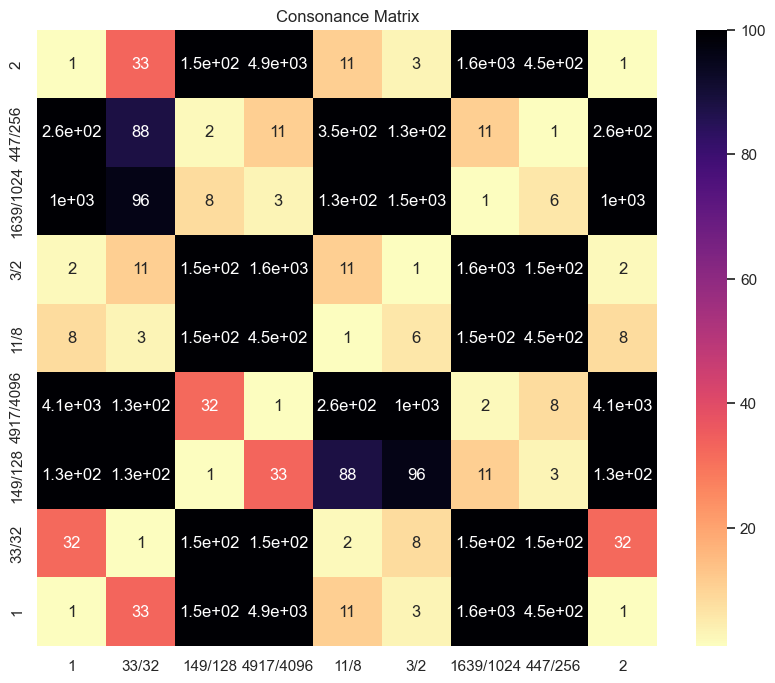

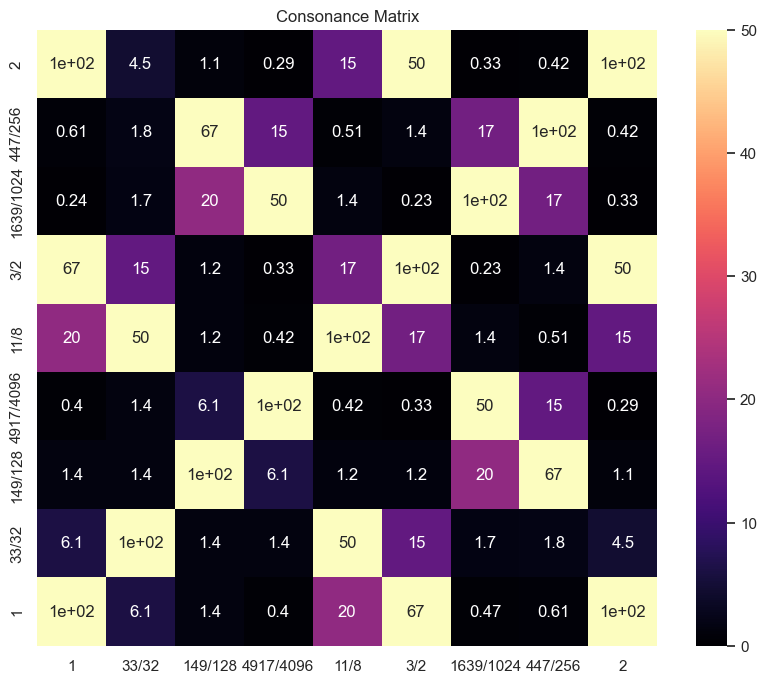

In [29]:
scale = biotuning.euler_fokker_scale(method='extended_peaks', octave = 2)
cons_matrix = consonance_matrix(scale, vmin = 1, vmax = 100, cmap = 'magma_r', fig = None)
cons_matrix_harmsim = consonance_matrix(scale, metric_function = dyad_similarity,
                                        vmin = 0, vmax = 50, cmap = 'magma', fig = None)

## 9. Computing scale metrics 

The harmonicity of a scale can be assessed by different metrics.

#### From peaks ratios

In [30]:
from biotuner.metrics import tuning_to_metrics
metrics_peaks = tuning_to_metrics(biotuning.peaks_ratios)
metrics_peaks

{'sum_p_q': 211,
 'sum_distinct_intervals': 38,
 'metric_3': 21.5746031746032,
 'sum_p_q_for_all_intervals': 8497,
 'sum_q_for_all_intervals': 3508,
 'harm_sim': 27.5,
 'matrix_harm_sim': 9.289929639476492,
 'matrix_cons': 0.0972719610995822,
 'matrix_denom': 60.25}

#### From harmonic entropy tuning

In [31]:
metrics_peaks = tuning_to_metrics(biotuning.HE_scale)
metrics_peaks

{'sum_p_q': 29847,
 'sum_distinct_intervals': 420,
 'metric_3': 151.999002802882,
 'sum_p_q_for_all_intervals': 901446,
 'sum_q_for_all_intervals': 416490,
 'harm_sim': 0.58,
 'matrix_harm_sim': 0.396151170895823,
 'matrix_cons': 0.0039701875712443635,
 'matrix_denom': 945.5333333333333}

## 10. Visualizing ratios with Lissajous curves

A Lissajous curve is the graph of a system of parametric equations which describe the superposition of two perpendicular oscillations in x and y directions of different angular frequency (a and b). Hence, it allows to visualize ratio (a/b).

Thanks to https://glowingpython.blogspot.com/2011/12/lissajous-curves.html

[8/7, 16/13, 23/16, 13/8, 23/14, 7/4, 23/13, 13/7, 2]


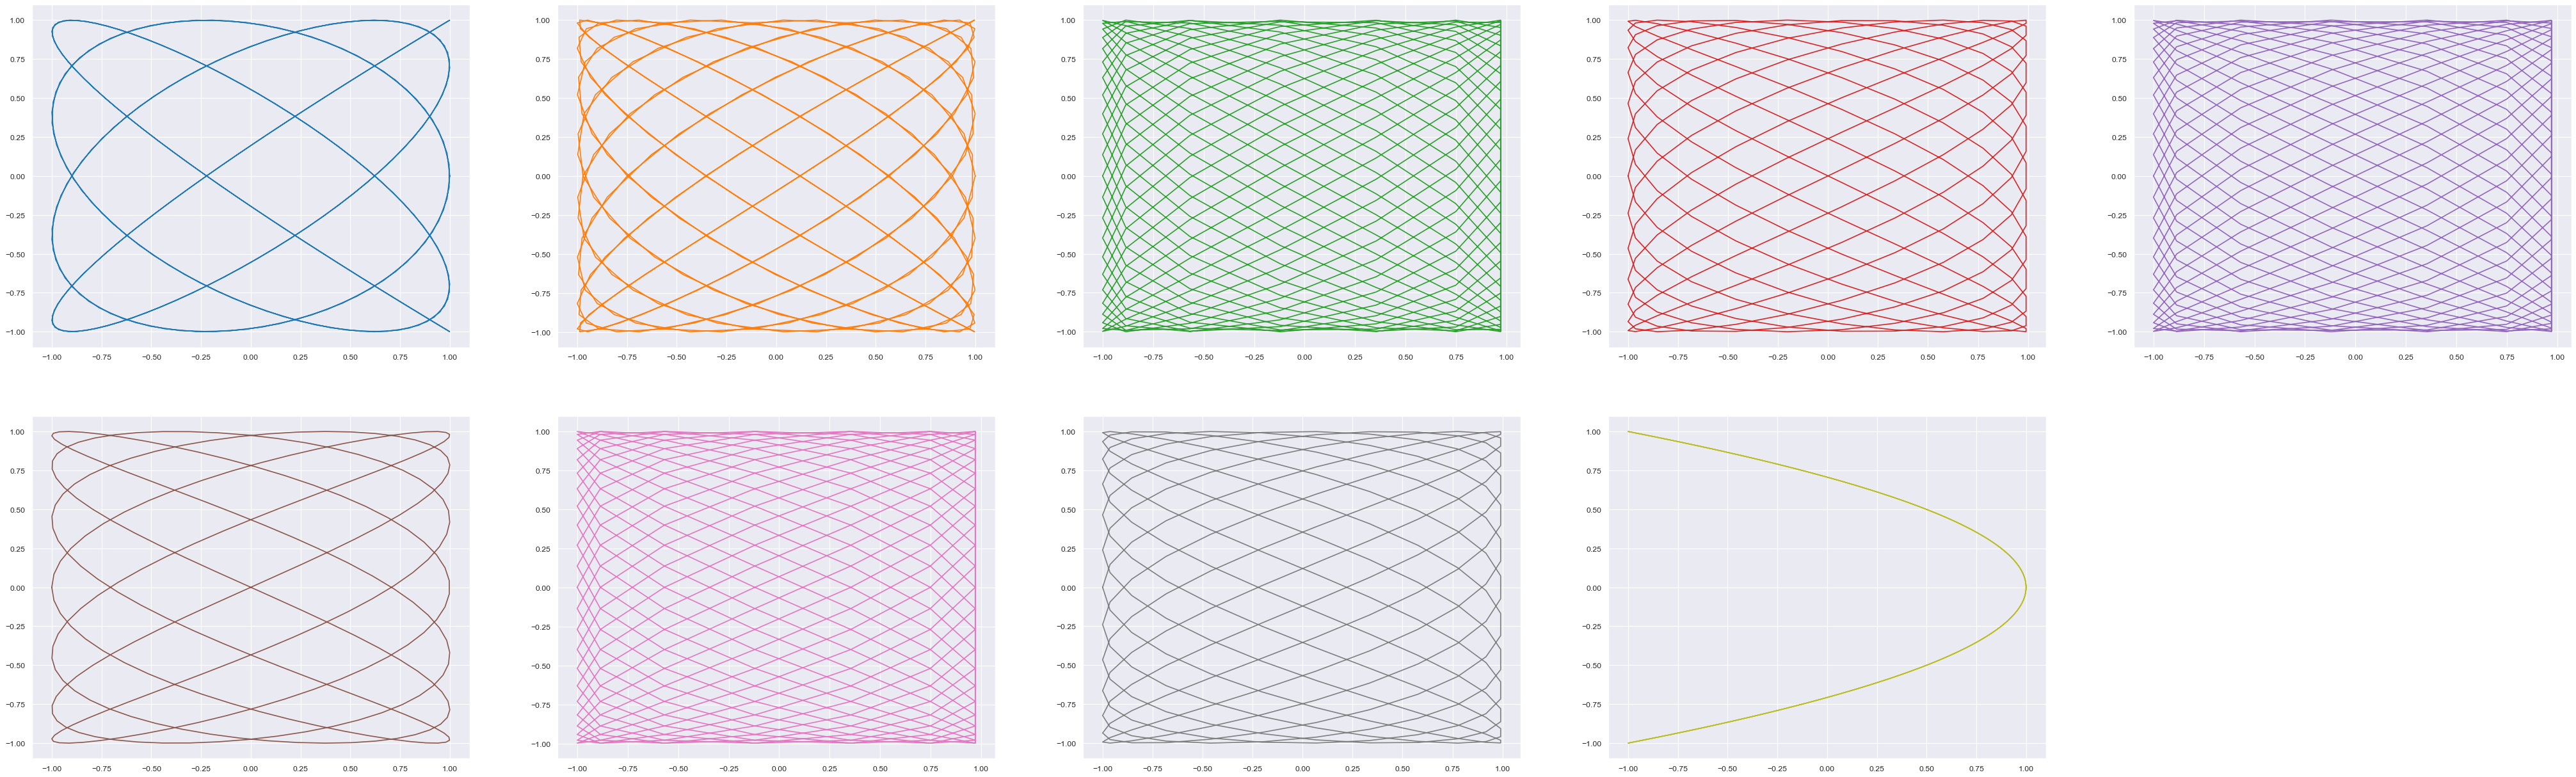

In [32]:
from biotuner.vizs import lissajous_curves
tuning = biotuning.harmonic_fit_tuning
tuning = biotuning.peaks_ratios
lissajous_curves(tuning)

[1, 263/250, 1113/1000, 1171/1000, 1239/1000, 1303/1000, 1379/1000, 1451/1000, 307/200, 323/200, 1797/1000, 2]


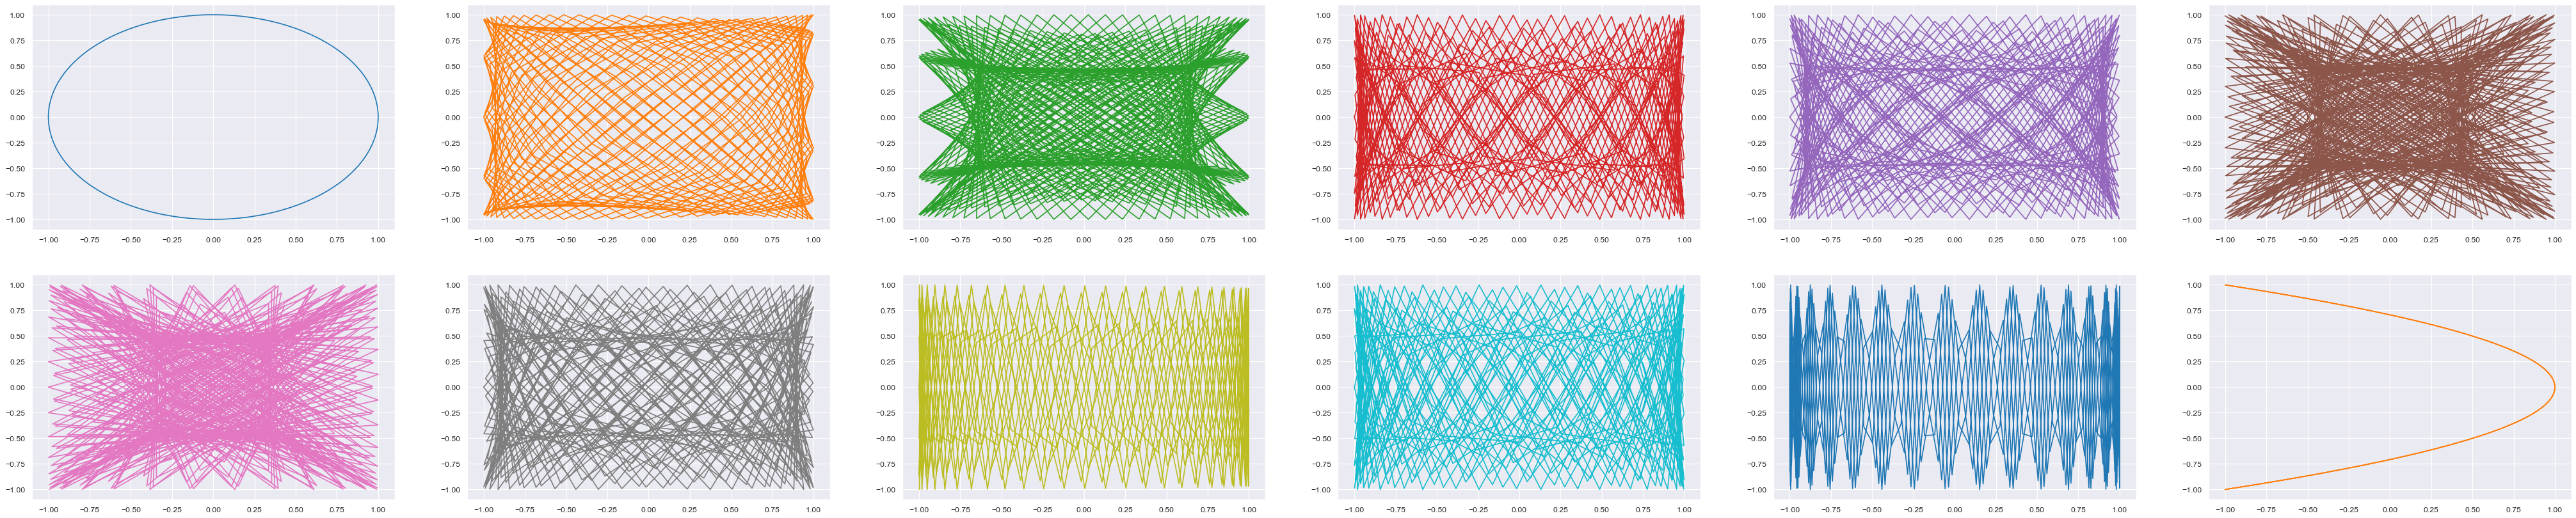

In [33]:
lissajous_curves(gen_interval_tuning)

## 11. Listening to scales



In [44]:
import biotuner
from biotuner.biotuner_utils import listen_scale
listen_scale(biotuning.peaks_ratios, 250, 500)

Scale: [1.1428571428571428, 1.2307692307692308, 1.4375, 1.625, 1.6428571428571428, 1.75, 1.7692307692307692, 1.8571428571428572, 2.0]
250
285.7142857142857
307.69230769230774
359.375
406.25
410.7142857142857
437.5
442.30769230769226
464.2857142857143
500.0


In [49]:
listen_scale(np.round(list(biotuning.HE_scale), 4), 100, 500)

Scale: [1.018 1.036 1.07  1.101 1.122 1.196 1.266 1.283 1.315 1.349 1.379 1.451
 1.494 1.57  1.603 1.646 1.71  1.792 1.818 1.927 1.967]
201.79999999999998
203.6
207.00000000000003
210.1
212.2
219.59999999999997
226.6
228.29999999999998
231.5
234.90000000000003
237.9
245.1
249.39999999999998
257.0
260.29999999999995
264.59999999999997
271.0
279.2
281.8
292.7
296.7
